## Reimburcements Time Series

I was wondering what the data would look like if viewed from the perspective of a time series.

My questions at the time were:
- Is there any seasonal pattern in the data?
- Is there any trend?
- Is it possible to make predictions about future reimburcemnts?

So lets see what we can discover...

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Only a few columns of the data are being loaded. That way grouping the data will be faster.

In [2]:
previous_years_data = pd.read_csv('../data/2016-08-08-previous-years.xz',
                   usecols = ['document_id', 'issue_date', 'month', 'year', 'congressperson_id', 'net_value'],
                   dtype={'document_id': np.str,
                          'congressperson_id': np.str,
                          'month': np.str,
                          'year': np.str})

last_year_data = pd.read_csv('../data/2016-08-08-last-year.xz',
                   usecols = ['document_id', 'issue_date', 'month', 'year', 'congressperson_id', 'net_value'],
                   dtype={'document_id': np.str,
                          'congressperson_id': np.str,
                          'month': np.str,
                          'year': np.str})

#Concatenating the datasets
data = pd.concat([last_year_data, previous_years_data])

#Joining month and year columns into a datetime field
data['month_year'] = pd.to_datetime(data['month']+'-'+data['year'], format='%m-%Y')

#Month and year colluns are not necessarie anymore
#data.drop('year', 1, inplace=True)
#data.drop('month', 1, inplace=True)

data.head()

,document_id,congressperson_id,issue_date,net_value,month,year,month_year
0,5886345,178957,2015-11-14T00:00:00,165.65,11,2015,2015-11-01
1,5886361,178957,2015-12-10T00:00:00,59.48,12,2015,2015-12-01
2,5886341,178957,2015-11-27T00:00:00,130.95,11,2015,2015-11-01
3,5928783,178957,2015-12-30T00:00:00,193.06,12,2015,2015-12-01
4,5608486,178957,2015-02-23T00:00:00,310.25,2,2015,2015-02-01


In [3]:
monthly_aggregate = {
    'congressperson_id': {
       'total': 'nunique'   
    },
    'net_value': {
        'mean': 'mean'
    }
}

monthly_group = data.groupby('month_year').agg(monthly_aggregate)
monthly_group.head()

,congressperson_id,net_value
,total,mean
month_year,,
2009-04-01,180,717.037767
2009-05-01,413,562.630617
2009-06-01,172,681.557857
2009-07-01,455,452.178851
2009-08-01,467,294.019011


The first graph is the number of unique `congressperson_id`s that appear each month. And the second graph is the monthly mean value paid.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1657b28438>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f166d1d3c50>], dtype=object)

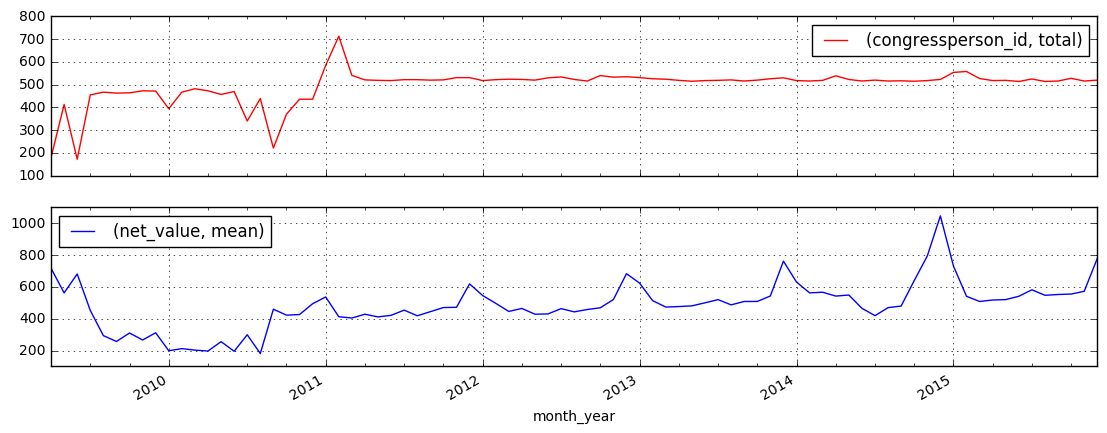

In [4]:
figsize = (8*(len(monthly_group.index)/48), 2.5*len(monthly_group.columns))
monthly_group.plot(figsize=figsize, color=['r', 'b', 'g'], grid='on', subplots=True)

### Questions

- Why the period before 2011 looks messy?
- From 2011 onwards a pattern appears. What is responsible for the raise in the mean at the end o each year?
- Why the mean gets higher at the end of 2014? Is it a reflex of the elections?
- Why the number of deputys getting reimburcements go up at the begining of 2011? Is it a kind of hype? There were changes in the law at that time?
- Is there a real trend on the reimburcements or is it just and effect of inflation?

PS.: Accoding to the [chamber's webpage](http://www2.camara.leg.br/a-camara/conheca/quantos-sao-e-de-que-forma-e-definido-o-numero-de-deputados) the number of deputys is 513 since 1993.

### Before going further on the previous questions... 

While wondering about the data another ideia came in mind: Can `issue_date` be used to replace the `month` and `year` fields so we are able to group data by day and week too?

Lets see what we can do...

The first questions is: There is any row with null `issue_date`s?

In [5]:
null_issue_date = data[data['issue_date'].isnull()]
null_issue_date.head()

,document_id,congressperson_id,issue_date,net_value,month,year,month_year
92,NaN,178957,NaN,99.44,6,2015,2015-06-01
93,NaN,178957,NaN,49.62,7,2015,2015-07-01
126,NaN,178957,NaN,758.69,8,2015,2015-08-01
127,NaN,178957,NaN,720.49,7,2015,2015-07-01
128,NaN,178957,NaN,652.50,6,2015,2015-06-01


In [6]:
len(null_issue_date.index)/len(data.index)

0.014476466006453767

It looks that ~1.45% of the dataset does not have an `issue_date`.

What we do with these rows?

We have two options: Drop them or fill them with the closest value!

But first, lets see if converting `issue_date` to a datetime field raises this percentage because of wrongly filled data

In [7]:
data['issue_date'] = pd.to_datetime(data['issue_date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [8]:
null_issue_date_after_convert = data[data['issue_date'].isnull()]
len(null_issue_date_after_convert.index)/len(data.index)

0.01448070493358131

The percentage changes almost nothing! So there are very few values with error...

I think its interesting to fill these rows because, as we can see below, all rows have `month` and `year` filled.

In [9]:
null_month_or_year = data[data['month'].isnull() | data['year'].isnull()]
len(null_month_or_year.index)

0

But first lets check something: Does the `month` or `year` column can be different from `data['issue_date'].dt.month` or `.year`? Lets check...

In [10]:
#Using month_year column to avoid comparison with different types
different_months = data[(data['issue_date'].dt.month != data['month_year'].dt.month) | (data['issue_date'].dt.year != data['month_year'].dt.year)]
print(len(different_months.index), len(different_months.index)/len(data.index))

117017 0.062003316960477305


As we can see ~6.2% of the data has a `month` or `year` column different from the month and year of the `issue_date`. So why not just fill the null `issue_date`s?

In [11]:
data['issue_date'] = data['issue_date'].fillna(method='ffill')

Now we have the null `issue_date` rows filled with a valid date that comes right before it.

In [12]:
different_months_after_fill = data[(data['issue_date'].dt.month != data['month_year'].dt.month) | (data['issue_date'].dt.year != data['month_year'].dt.year)]
print(len(different_months_after_fill.index), len(different_months_after_fill.index)/len(data.index))

115795 0.06135582084174496


Well, the percentage accualy droped. That's good!

Now lets try to plot a graph from `issue_date`...

In [13]:
daily_aggregate = {
    'congressperson_id': {
       'total': 'nunique'   
    },
    'net_value': {
        'mean': 'mean'
    }
}

daily_group = data.groupby('issue_date').agg(daily_aggregate)
daily_group.head()

,congressperson_id,net_value
,total,mean
issue_date,,
2001-01-03,2,77.01
2001-01-06,1,2490.00
2001-01-10,1,8980.00
2001-02-01,1,80.00
2001-02-07,1,823.82


In [14]:
len(data[(data.issue_date.dt.year < 2009) | (data.issue_date.dt.year > 2015)].index)

3303

It looks like there are some rows with an `issue_date` that is out of the range of the `month` and `year` columns combined. These rows deserve a better look.

Lets filter these rows out so we can continue.

In [15]:
daily_aggregate = {
    'congressperson_id': {
       'total': 'nunique'   
    },
    'net_value': {
        'mean': 'mean'
    }
}

filtered_data = data[(data['issue_date'].dt.year >= 2009) & (data['issue_date'].dt.year <= 2015)]
filtered_daily_group = filtered_data.groupby('issue_date').agg(daily_aggregate)
filtered_daily_group.head()

,congressperson_id,net_value
,total,mean
issue_date,,
2009-04-29,111,796.057784
2009-04-30,84,599.145000
2009-05-01,7,650.448571
2009-05-02,5,624.293333
2009-05-03,4,421.120000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f166b9cb6d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f166b9a7d68>], dtype=object)

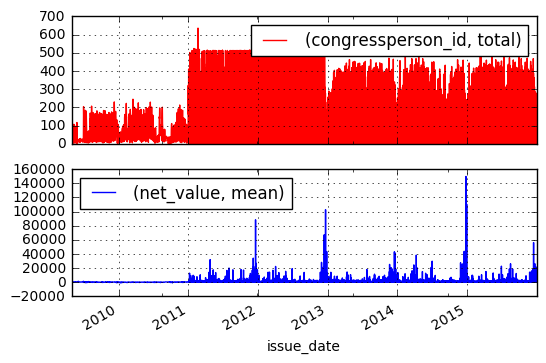

In [16]:
filtered_daily_group.plot(color=['r', 'b', 'g'], grid='on', subplots=True)

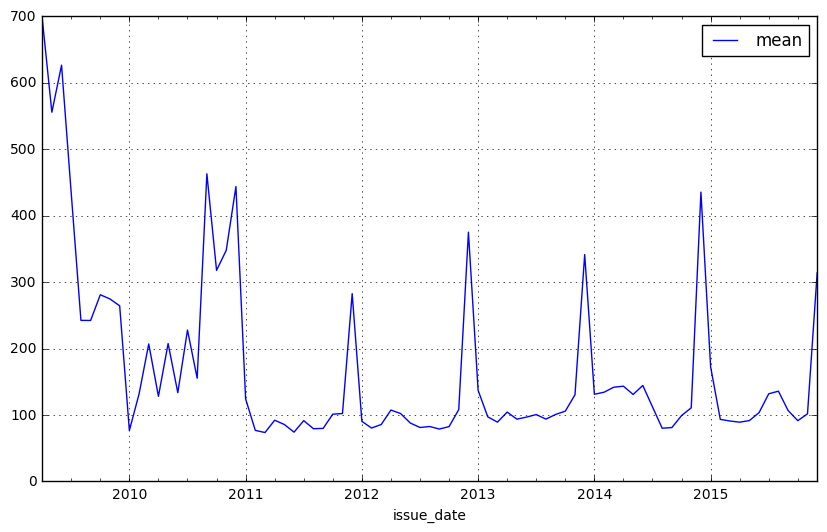

In [17]:
filtered_daily_group['net_value'].resample('M').mean().plot(figsize=(10, 6), grid='on')

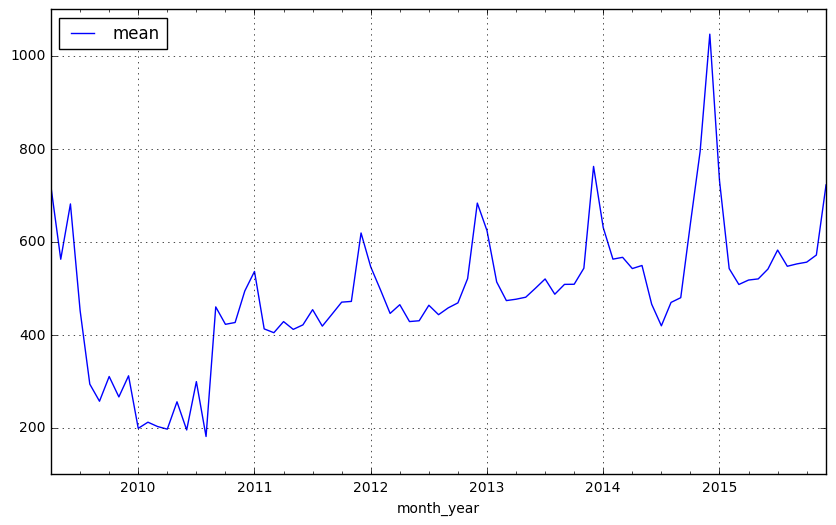

In [18]:
filtered_monthyear_group = filtered_data.groupby('month_year').agg(daily_aggregate)
filtered_monthyear_group['net_value'].plot(figsize=(10, 6), grid='on')